In [ ]:
# Do you want to use jupyter default light background?
!jt -r 
# Do you want to see a list of available teams?
!jt -l
#Do you want to set an specific team?
#!jt -t onedork

**Nice extensions to use**
1. (some) $\LaTeX $ evironments for Jupyter
2. *Code Font Size* (useful for presentations)
3. *Codefolding Editor* (collapsible functions, classes and loops)
4. *contrib_nbextensions_help_item* (leave it)
5. *ExecuteTime* (stamp all the cells)
6. *Highlight selected word (search for the selected word in all notebook)*
7. *highlighter* 
8. *Hinterland* (useful autocompletion, but you should disable continous mode in HELP menu item)
9. *Navigation-Hotkeys* (pgUP and pgDown for notebooks)
10. *NBextensions dashboard tab* (insert a cell for you to mess around)
11. *NBextensions edit menu item* 
12. *RISE* (revealJS interface for slideshow) 
13. *Scratchpad* (CTLB-B toggle the scratchpad cell
14. *spellchecker* (works in Markdown or Raw cells)
15. *Toggle all line numbers* 
16. *Variable Inspector* (debug watch)
17. *Comment/Uncomment Hotkey* (default Alt-c)

In [ ]:
# # Do you have some changes to commit to the container?
# # You can do it from here or from a terminal 
# !conda deactivate
# !conda activate cosmos3 
# !pip install statsmodels 
# !pip install sklearn
# !docker commit bingo-hackaton lbarosi/bingo-hackaton:NEWIMAGE
# # Next time you may run the new image with make run-jupyter TAG=NEWIMAGE


# BINGO Hackaton 

**Luciano Barosi**

*BINGO Collaboration*


## Correlations

We want to study cosmological signals in this course, today we show the very basic examples that we want to deal with and we are going to construct this piece by piece later. 
We will need to understand how to create random points and circles, calculate correlations, do histograms and use gaussian kernel density estimators.
At the end of this lesson you should have a feeling of what mean to work in the flat sky aproximation and what is the meaning of autocorrelation in BAO detection (or any other feature detection)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import healpy as hp # pixelated data on the sphere
import matplotlib.cm as cm # colormaps
import scipy.stats as stats # probability density function
from sklearn.neighbors import KernelDensity # kernel density estimator
from scipy import fftpack

In [2]:
%matplotlib inline

In [4]:
#Set the size of the figures 
plt.rcParams['figure.figsize'] = (16.0, 6.0)

In [5]:
#Before we start plotting the CMB let's set a nice cmap
cmap = cm.RdBu_r
cmap.set_under("w") # sets background to black

In [6]:
# show result from all calculations of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
# healpy needs MASKED ARRAYS. 
white_noise = np.ma.asarray(np.random.normal(0, 0.0001, 12*1024**2))
# from https://pla.esac.esa.int/
planck_IQU_SMICA = hp.read_map('../DATA/COM_CMB_IQU-smica_1024_R2.02_full.fits')

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/opt/conda/envs/cosmos3/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


In [8]:
# Now we understand why we choose that size for white_noise
white_noise.shape
planck_IQU_SMICA.shape

(12582912,)

(12582912,)

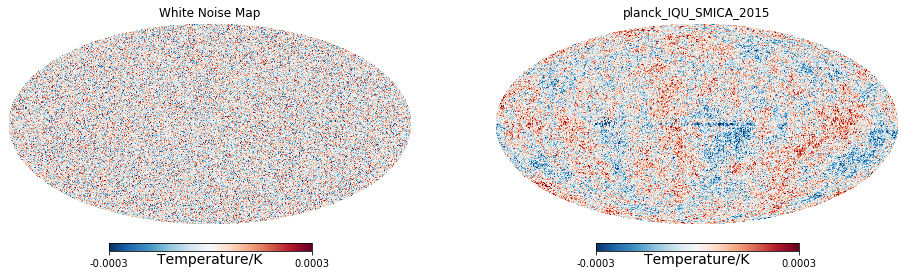

In [9]:
# hold option does the magic to plot side by side
fig, (ax1, ax2) = plt.subplots(ncols=2)
plt.axes(ax1)
hp.mollview(white_noise, min=-0.0003, max=0.0003, title='White Noise Map', 
            fig=1, unit=r'Temperature/K', cmap=cmap, hold=True)   
plt.axes(ax2)
hp.mollview(planck_IQU_SMICA, min=-0.0003, max=0.0003, title='planck_IQU_SMICA_2015',
            fig=2, unit=r'Temperature/K', cmap=cmap, hold=True)
plt.show();

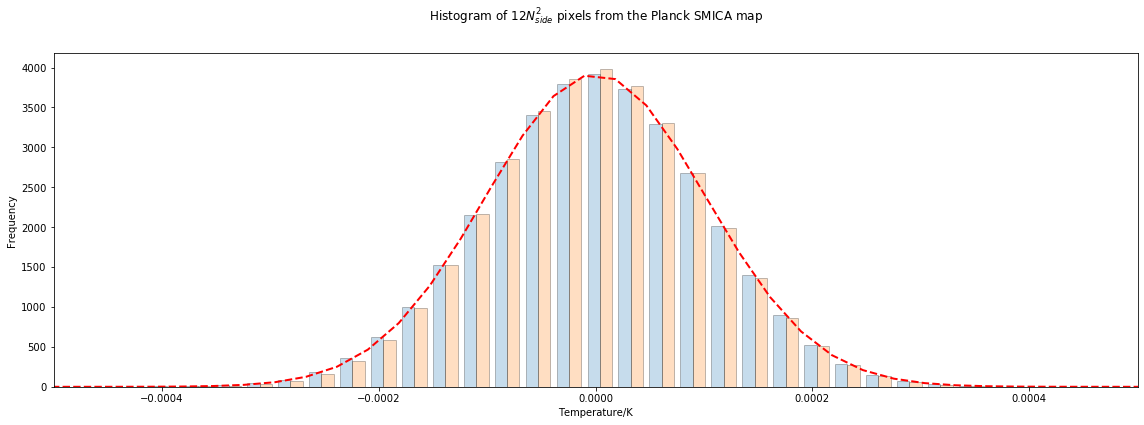

In [10]:
# Take temperatures and fit a gaussian
(mu_p, sigma_p) = stats.norm.fit(planck_IQU_SMICA)
# the histogram of both data side by side
n, bins, patches = plt.hist((planck_IQU_SMICA,white_noise), 60, density=1, 
                            edgecolor = 'black', alpha=0.25)
# add a 'best fit' line
y_p = stats.norm.pdf(bins, mu_p, sigma_p)
l = plt.plot(bins, y_p, 'r--', linewidth=2)

plt.xlabel('Temperature/K')
plt.ylabel('Frequency')
plt.title(r'Histogram of $12N_{side}^2$ pixels from the Planck SMICA map', y=1.08)
plt.xlim(-0.0005, 0.0005)

plt.tight_layout();

In [11]:
# We are ignoring beam convolution
# Let's compute the power spectrum directly with healpy.anafast
cl_SMICA = hp.anafast(planck_IQU_SMICA, lmax=1024)
ell = np.arange(len(cl_SMICA))
dl_SMICA = cl_SMICA
# Commonn plot is l(l+1)C/2pi
dl_SMICA = (ell * (ell + 1) * dl_SMICA/ (2*np.pi))  / 1e-12
######################################################
# Cls for white noise
cl_white = hp.anafast(white_noise, lmax=1024)
dl_white = (ell * (ell + 1) * cl_white / (2*np.pi)) / 1e-12

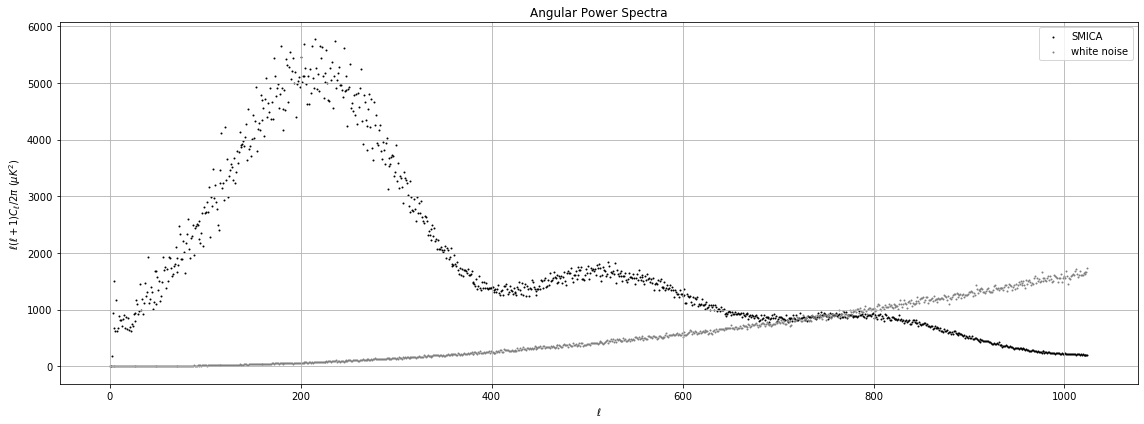

In [12]:
# Even though both signals are gaussian, they have ery different power spectra.
fig = plt.figure(3)
ax = fig.add_subplot(111)
ax.scatter(ell, dl_SMICA,
           s=4, c='black', lw=0, 
           label='SMICA')
ax.scatter(ell, dl_white,
           s=4, c='gray', lw=0,
           label='white noise')
ax.set_xlabel('$\ell$')
ax.set_ylabel('$\ell(\ell+1)C_\ell/2\pi \,\,(\mu K^2)$ ')
ax.set_title('Angular Power Spectra')
ax.legend(loc='upper right')
ax.grid()

plt.tight_layout();

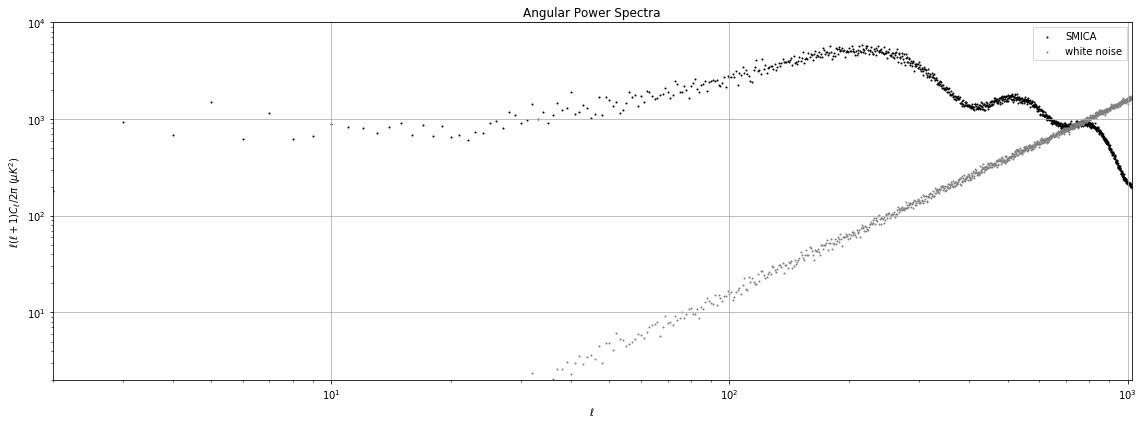

In [13]:
# Logplot show white noise l(l+1)Cls are a powerlaw
fig = plt.figure(3)
ax = fig.add_subplot(111)
ax.scatter(ell, dl_SMICA,
           s=4, c='black', lw=0, 
           label='SMICA')
ax.scatter(ell, dl_white,
           s=4, c='gray', lw=0,
           label='white noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\ell$')
ax.set_ylabel('$\ell(\ell+1)C_\ell/2\pi \,\,(\mu K^2)$ ')
ax.set_title('Angular Power Spectra')
ax.legend(loc='upper right')
ax.grid()

ax.set_xlim(2, 1024)
ax.set_ylim(2, 10000)

plt.tight_layout();

In [14]:
hp.__version__
#!pip install healpy --upgrade
# If your version of healpy is not > 1.12.10 you won't be able to interact below. 
# I chose to omit the interation with mollzoom

'1.12.10'

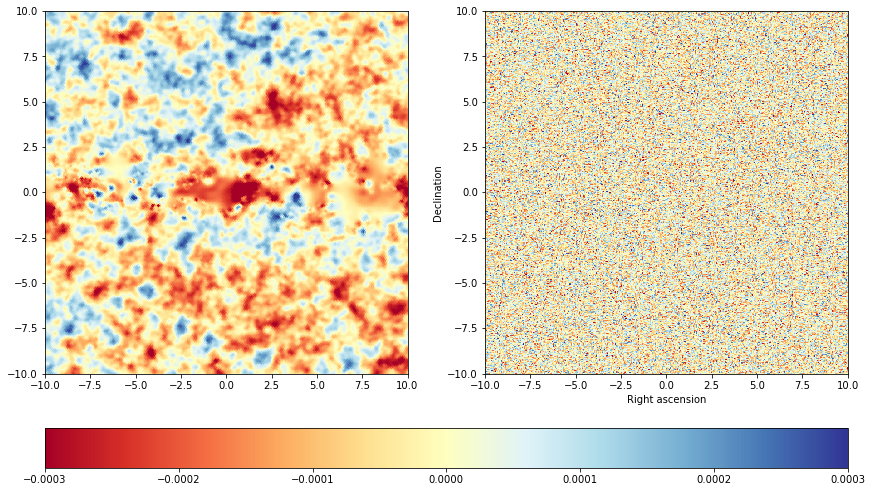

In [15]:
#turn output off
%matplotlib agg
%matplotlib agg
# Celestial coordinates interval
lonra = [-10,10]
latra = [-10,10]
# Cartesian projection of a region of the sky
planck=hp.cartview(planck_IQU_SMICA, return_projected_map=True, coord="C", lonra=lonra, latra=latra);
noise=hp.cartview(white_noise, return_projected_map=True, coord="C", lonra=lonra, latra=latra);
#Turn output on
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0)
# Plot side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
im1 = ax1.imshow(planck,  extent=[-10,10,-10,10], cmap=plt.cm.RdYlBu, aspect='equal', 
                norm=colors.Normalize(vmin=-0.0003,vmax=0.0003))
plt.xlabel('Right ascension')
plt.ylabel('Declination')
im2 = ax2.imshow(noise,  extent=[-10,10,-10,10], cmap=plt.cm.RdYlBu, aspect='equal', 
                norm=colors.Normalize(vmin=-0.0003,vmax=0.0003))

cbar = fig.colorbar(im1, ax=(ax1,ax2), location = "bottom")
plt.show();

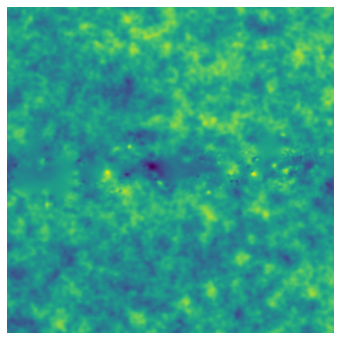

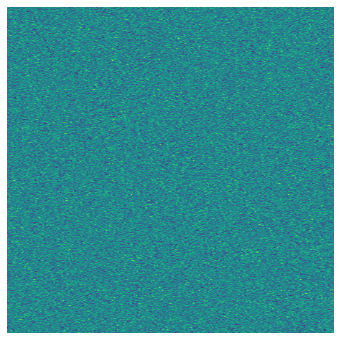

In [24]:
# Another way to get portions of the sky
# %matplotlib agg
# %matplotlib agg
# Define X and Y range of coordinates
lonrange = np.linspace(-10,10,3000)
latrange = np.linspace(-10,10,3000)
# create a mesh of 2D coordinates
X2D,Y2D = np.meshgrid(latrange,lonrange)
# interpolate the values using the map indicated in all mesh points
# this is a 1D array of Z values
# Saving the portions with no ticks, axis and tight. 
# We will work in this images soon 
interp = hp.get_interp_val(planck_IQU_SMICA, X2D, Y2D, lonlat=True)
fig = plt.figure()
plt.imshow(interp, extent=(-10,10,-10,10))
plt.axis('off')
# fig.savefig("plancktest.png", bbox_inches="tight" );
##############################################################
interpW = hp.get_interp_val(white_noise, X2D, Y2D, lonlat=True)
fig = plt.figure()
plt.imshow(interpW, extent=(-10,10,-10,10))
plt.axis("off")
#fig.savefig("white_noise.png", bbox_inches="tight");
plt.show();

In [23]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 6.0)

In [44]:
X2D.shape

(3000, 3000)

In [ ]:
# We want to FFT te images, first we need to convert to grayscale.
# There are lots of ways of accomplishing this. 
# I chose a not so good but fast way
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
# Reading the images
imColor = plt.imread("plancktest.png")
imColorW = plt.imread("white_noise.png")
# Converting images to grayscale
im = rgb2gray(imColor)
imW = rgb2gray(imColorW)
# 2D fourier transform and arrange the frequencies with low frequencies at the center
im_fft = fftpack.fft2(im)
ftimage = np.fft.fftshift(im_fft)

im_fftW = fftpack.fft2(imW)
ftimageW = np.fft.fftshift(im_fftW)
# Fourier transform will need a logscale to be visible
from matplotlib.colors import LogNorm 

fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True)
ax1.imshow(np.abs(ftimage), extent=(-10,10,-10,10), norm=LogNorm(vmin=1), cmap=plt.cm.RdYlBu)
ax2.imshow(np.abs(ftimageW), extent=(-10,10,-10,10), norm=LogNorm(vmin=1), cmap=plt.cm.RdYlBu)
plt.show();
# No problem in using a nice colormap to visualize it.

In [ ]:
# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.2
keep_fraction2 = 0.5

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
im_fft2 = ftimage.copy()
im_fftLOW = ftimage.copy()
# Set r and c to be the number of rows and columns of the array.
r, c = im_fft2.shape
# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
# Similarly with the columns:
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2)

lx, ly = im_fftLOW.shape
X, Y = np.ogrid[0:lx, 0:ly]
mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 50

im_fftLOW[mask] = 0
im_newLOW = fftpack.ifft2(im_fftLOW)


fig, axes = plt.subplots(2, 3, constrained_layout=True)
axes[0,0].imshow(im, extent=(-10,10,-10,10), cmap=plt.cm.RdYlBu)
axes[0,1].imshow(np.abs(im_new), extent=(-10,10,-10,10), cmap=plt.cm.RdYlBu)
axes[0,2].imshow(np.abs(im_newLOW), extent=(-10,10,-10,10), cmap=plt.cm.RdYlBu)
axes[1,0].imshow(np.abs(ftimage), extent=(-10,10,-10,10), norm=LogNorm(), cmap=plt.cm.RdYlBu)
axes[1,1].imshow(np.abs(im_fft2), extent=(-10,10,-10,10), norm=LogNorm(), cmap=plt.cm.RdYlBu)
axes[1,2].imshow(np.abs(im_fftLOW), extent=(-10,10,-10,10), norm=LogNorm(), cmap=plt.cm.RdYlBu)
plt.show();

#### Exercise:
Reproduce the piece of code above for white noise and think about the amount of information in low and high frequencies.

## White Noise

We just saw some cosmological signals, now let's look at random noise in detail.

In [ ]:
def randomPoints(points=100, rseed=1):
    """Determine a set of 2D random points from choosen distribution
    
    Parameters
    ----------
    points : int
        Number of points to be drawn
    rseed : integer, optional
        seed for RandomState, for reproducibility
    
    Returns
    -------
    array
        XY
     
    Raises
    ------
    ValueError
        If dist if not ("normal","uniform")
    """
    # for reproducibility
    rand = np.random.RandomState(rseed)
    XY = np.random.random((points,2))
        
    return XY

def distances(XY):
    """ Calculate distance between all the points given as arguments and returns
        a list of this distances, excluding repeated distances and zeros.
    Parameters
    ----------
    array: (X,Y) coordinates
        
    Returns
    ------- 
    array: list of distances
    """
    X = XY[:,0]
    Y = XY[:,1]
    len = X.shape[0]
    X,Y = np.atleast_2d(X, Y)
    D = np.sqrt( (X-X.T)**2 + (Y-Y.T)**2)
    # exclude distance with the same point
    dist = D[np.triu_indices(len,1)]
    
    return dist

def drawCircle(X, Y, rr = .3, samples = 100):
    """Draw samples points along circles with center in X, Y
    Parameter
    ---------
    X : array of positions in x axis 
    Y : array of positions in y axis
    rr : float, radius 
    samples : int, number of points per circle 
    
    Returns
    -------
    2D arrays
        X2
    """
    theta = np.linspace(0,2*np.pi,samples)
    xc = rr*np.cos(theta)
    XX = (xc + np.tile(X, (samples,1)).T).reshape(-1)

    yc = rr*np.sin(theta)
    YY = (yc + np.tile(Y, (samples,1)).T).reshape(-1)
    # Bounding box
    circ = np.vstack((XX,YY)).T
    masked = circ[(circ[:,0]>0) & (circ[:,0] <=1) & 
                  (circ[:,1]>0) & (circ[:,1] <=1)]
    
    return masked

    

In [ ]:

XY = randomPoints(points = 10)
Z = distances(XY)
circ = drawCircle(XY[:,0],XY[:,1], samples = 100)
points = np.vstack((XY, circ))
Zt = distances(points)
fig = plt.figure()
plt.scatter(XY[:,0],XY[:,1])
plt.scatter(circ[:,0],circ[:,1])
plt.show();


In [ ]:
plt.hist(Z, bins = 5, density=10)
plt.hist(Zt, bins = 200, density=10, alpha = 0.5)
plt.tight_layout();

In [ ]:
# Silverman's Rule of Thumb
binEstimate = stats.variation(Zt)*(4/(3*len(Zt)))**(1/5)
binEstimate

In [ ]:
Zt.shape

In [ ]:
# WARNING: non-efficient implementation
from scipy.stats import norm
bins = 100
x_d = np.linspace(0, 2, bins)
binwidth = binEstimate
density = sum(norm.pdf(x_d, loc=xi, scale=binwidth)/len(Zt) for xi in Zt)

plt.fill_between(x_d, density, alpha=0.5)

plt.show();

In [ ]:
# This is the vectorized version of the cell above.
# Since the function must take TWO arrays you have to provide them in different shapes.
# One should be a row and the other a column vector.
# reshape(-1,1) takes a row vector and transforms into a column 
density = sum(norm.pdf(x_d, loc = Zt.reshape(-1,1), scale=binwidth)/len(Zt))
fig = plt.figure()
plt.fill_between(x_d, density, alpha=0.5)
# This plots the tickmarks below to show where our points lie in x-axis
plt.plot(Z, np.full_like(Z, -0.001), '|k', markeredgewidth=1)
plt.show();

In [ ]:

x_d = np.linspace(0, 2, 1000)
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
kde.fit(Zt[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.show();